# Step 1: Gather Data

For this final project, we will use the **CIFAR-10** image classification dataset:
- **Data Source:** TensorFlow / Keras
- **Collection Method:** Images were scraped from the internet and manually labeled by the CIFAR research team.
- **Provenance:** Publically available via TensorFlow Datasets and Keras

The dataset contains 60000 color images (32 x 32 pixels) in 10 classes:
- 50000 training images
- 10000 test images

This benchmark is widely used for evaluated deep convolutional neural networks on small-image classification tasks.

# Step 2: Identify a Deep Learning Problem

**Problem Statement:**
Build a deep convolutional neural network to classify images in the CIFAR-10 dataset into one of 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).

**Key Challenges:**
- **Low Resolution (32x32):** Models must learn robust features from small images.
- **High Intra-Class Variability:** Objects appear at different scales, lighting, and backgrounds.
- **Generalization v.s. Overfitting:** With only 50k training images, architecture and regularization choices are critical.

**Proposed Approaches:**
1. **Baseline CNN:** A simple 4-6 layer ConvNet to establish a reference accuracy.
2. **ResNet-18:** Leverage residual connections to train deeper networks more easily.
3. **EfficientNet-B0:** Explore compound scaling for a good accuracy/efficiency trade-off.

Additionally, we perform hyperparameter optimization.

# Step 3: Exploratory Data Analysis

## 3.1 Data Overview

In [6]:
import numpy as np
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test:  {x_test.shape},  y_test:  {y_test.shape}")

print("Any NaNs in x_train?", np.isnan(x_train).any())
print("Any NaNs in x_test?",  np.isnan(x_test).any())

x_train: (50000, 32, 32, 3), y_train: (50000, 1)
x_test:  (10000, 32, 32, 3),  y_test:  (10000, 1)
Any NaNs in x_train? False
Any NaNs in x_test? False


## 3.2 Class Distribution
As seen below, each class contains exactly 5000 data samples in the training set

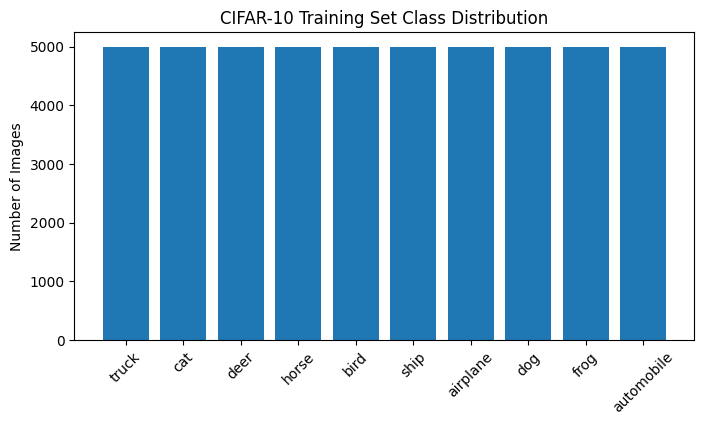

In [10]:
import matplotlib.pyplot as plt
from collections import Counter

labels = y_train.flatten()
counts = Counter(labels)
classes = list(counts.keys())
freqs   = [counts[c] for c in classes]

class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

plt.figure(figsize=(8,4))
plt.bar(classes, freqs, tick_label=class_names)
plt.xticks(rotation=45)
plt.title("CIFAR-10 Training Set Class Distribution")
plt.ylabel("Number of Images")
plt.show()

## 3.3 Samples Images per Class

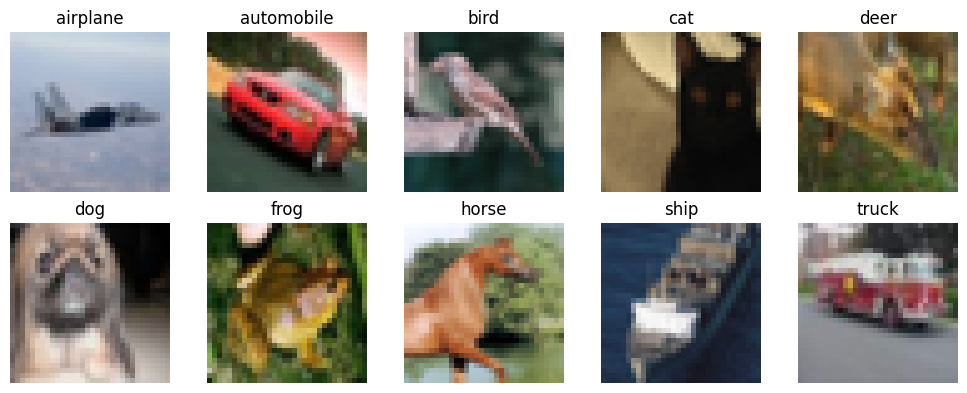

In [11]:
import random

plt.figure(figsize=(10,4))
for i, cls in enumerate(range(10)):
    idx = random.choice(np.where(labels == cls)[0])
    img = x_train[idx]
    plt.subplot(2,5,i+1)
    plt.imshow(img)
    plt.title(class_names[cls])
    plt.axis('off')
plt.tight_layout()
plt.show()

## 3.4 Pixel Intensity Distribution

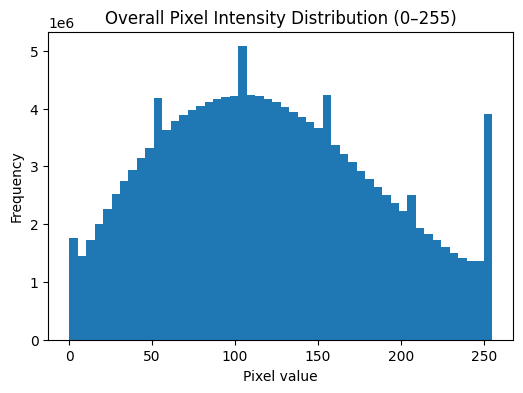

In [12]:
all_pixels = x_train.reshape(-1, 3)
plt.figure(figsize=(6,4))
plt.hist(all_pixels.flatten(), bins=50)
plt.title("Overall Pixel Intensity Distribution (0–255)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

## 3.5 Dataset Channel Statistics

In [13]:
x_norm = x_train.astype('float32') / 255.0
mean = x_norm.mean(axis=(0,1,2))
std  = x_norm.std(axis=(0,1,2))
print("Channel means:", mean)
print("Channel stds: ", std)

Channel means: [0.4914009  0.48215896 0.4465308 ]
Channel stds:  [0.24703279 0.24348423 0.26158753]


# Step 4: Model Training & Evaluation

Below is the code to train and evaluate all three architectures on CIFAR-10.

## 4.1 Prepare Data

In [14]:
from sklearn.model_selection import train_test_split

x_train_norm = (x_train.astype('float32') / 255.0 - mean) / std
x_test_norm  = (x_test.astype('float32') / 255.0 - mean) / std

x_train_sub, x_val, y_train_sub, y_val = train_test_split(
    x_train_norm, y_train,
    test_size=0.10,
    stratify=y_train,
    random_state=42
)

print("Train:", x_train_sub.shape, y_train_sub.shape)
print("Val:  ", x_val.shape,     y_val.shape)
print("Test: ", x_test_norm.shape, y_test.shape)

Train: (45000, 32, 32, 3) (45000, 1)
Val:   (5000, 32, 32, 3) (5000, 1)
Test:  (10000, 32, 32, 3) (10000, 1)


## 4.2 Define Model Architectures

In [2]:
from tensorflow.keras import layers, models

# 4.2.1 Baseline 4-Layer CNN
def build_baseline_cnn(input_shape=(32,32,3), num_classes=10):
    model = models.Sequential([
        layers.Conv2D(32,3,padding='same', activation='relu', input_shape=input_shape),
        layers.Conv2D(32,3,padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Conv2D(64,3,padding='same', activation='relu'),
        layers.Conv2D(64,3,padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax'),
    ])
    return model

# 4.2.2 ResNet-18 for CIFAR
def conv_block(x, filters, strides):
    x = layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    return layers.ReLU()(x)

def residual_block(x, filters, downsample=False):
    stride = 2 if downsample else 1
    y = conv_block(x, filters, stride)
    y = layers.Conv2D(filters, 3, strides=1, padding='same', use_bias=False)(y)
    y = layers.BatchNormalization()(y)
    if downsample:
        x = layers.Conv2D(filters, 1, strides=2, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
    out = layers.Add()([x, y])
    return layers.ReLU()(out)

def build_resnet18(input_shape=(32,32,3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = conv_block(inputs, 64, strides=1)
    # Four stages, two blocks each
    for filters in [64,128,256,512]:
        x = residual_block(x, filters, downsample=(filters!=64))
        x = residual_block(x, filters, downsample=False)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

# 4.2.3 EfficientNet-B0
from tensorflow.keras.applications import EfficientNetB0

def build_efficientnetb0(input_shape=(32,32,3), num_classes=10):
    base = EfficientNetB0(
        input_shape=input_shape, 
        weights=None,
        include_top=False
    )
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(base.input, outputs)

## 4.3 Compile, Train & Evaluate

In [8]:
import tensorflow as tf
batch_size = 64
epochs     = 30

model_builders = {
    'BaselineCNN': build_baseline_cnn,
    'ResNet18':    build_resnet18,
    'EffNetB0':    build_efficientnetb0
}

histories    = {}
test_metrics = {}

for name, build_fn in model_builders.items():
    print(f"\n=== Training {name} ===")
    model = build_fn()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    histories[name] = model.fit(
        x_train_sub, y_train_sub,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=2
    )
    test_metrics[name] = model.evaluate(x_test_norm, y_test, verbose=2)
    print(f"{name} test loss, acc = {test_metrics[name]}")


=== Training BaselineCNN ===


/Users/jeffreylind/anaconda3/envs/Temp/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
704/704 - 69s - 99ms/step - accuracy: 0.4635 - loss: 1.4790 - val_accuracy: 0.6336 - val_loss: 1.0441
Epoch 2/30
704/704 - 75s - 106ms/step - accuracy: 0.6384 - loss: 1.0290 - val_accuracy: 0.6888 - val_loss: 0.8868
Epoch 3/30
704/704 - 78s - 111ms/step - accuracy: 0.6986 - loss: 0.8587 - val_accuracy: 0.7286 - val_loss: 0.7598
Epoch 4/30
704/704 - 71s - 101ms/step - accuracy: 0.7317 - loss: 0.7627 - val_accuracy: 0.7442 - val_loss: 0.7229
Epoch 5/30
704/704 - 70s - 100ms/step - accuracy: 0.7577 - loss: 0.6918 - val_accuracy: 0.7600 - val_loss: 0.6713
Epoch 6/30
704/704 - 71s - 101ms/step - accuracy: 0.7748 - loss: 0.6359 - val_accuracy: 0.7726 - val_loss: 0.6568
Epoch 7/30
704/704 - 71s - 100ms/step - accuracy: 0.7915 - loss: 0.5927 - val_accuracy: 0.7874 - val_loss: 0.6277
Epoch 8/30
704/704 - 71s - 100ms/step - accuracy: 0.8063 - loss: 0.5494 - val_accuracy: 0.7812 - val_loss: 0.6293
Epoch 9/30
704/704 - 73s - 103ms/step - accuracy: 0.8168 - loss: 0.5216 - val_accuracy: 0

## 4.4 Plot Validation Accuracy Comparison

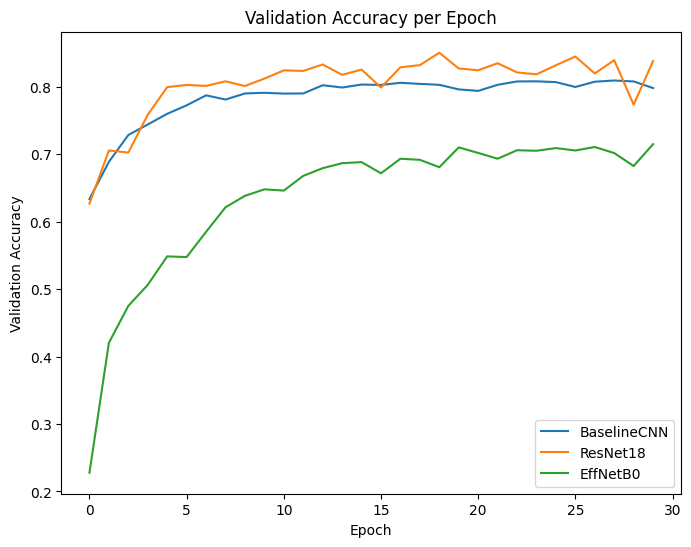

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for name, hist in histories.items():
    plt.plot(hist.history['val_accuracy'], label=f'{name}')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

## 4.5 Test Accuracies

| Model               | Test Accuracy |
|---------------------|---------------|
| **Baseline CNN**    | 79.01 %       |
| **ResNet-18**       | 82.84 %       |
| **EfficientNet-B0** | 69.99 %       |

- **ResNet-18** achieved the highest accuracy of 82.8%, validating the value of residual connections for learning deeper features on small images.
- The **Baseline CNN** reached an accuracy of 79%, with validation accuracy plateauing around epoch 10 while training accuracy continued to increase, indicating moderate overfitting
- **EfficientNet-B0** underperoformed the other models with an accuracy of 70% when trained from scratch on 32x32 images. The compound-scaling rules likely require either ImageNet pretraining or more epochs / stronger regularization to be effective at this resolution.
- All models show a significant gap between their train and val curves, suggesting that further regularization, data augmentation, or early stopping will be important to improve generalization.

## 4.6 Hyperparameter Optimization
To improve the Baseilne CNN's generalization, we performed a quick grid search over the initial learning rate hyperparameter. We train three version of the same 4-layer ConvNet for 10 epochs each, using learning ratess of 1e-2, 1e-3, and 1e-4, and compare their validation accuract curves,

Training BaselineCNN with lr = 0.01


/Users/jeffreylind/anaconda3/envs/Temp/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
704/704 - 31s - 44ms/step - accuracy: 0.0991 - loss: 2.3638 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 2/10
704/704 - 30s - 43ms/step - accuracy: 0.1005 - loss: 2.3036 - val_accuracy: 0.1000 - val_loss: 2.3032
Epoch 3/10
704/704 - 30s - 43ms/step - accuracy: 0.0983 - loss: 2.3036 - val_accuracy: 0.1000 - val_loss: 2.3033
Epoch 4/10
704/704 - 31s - 44ms/step - accuracy: 0.0992 - loss: 2.3037 - val_accuracy: 0.1000 - val_loss: 2.3035
Epoch 5/10
704/704 - 30s - 43ms/step - accuracy: 0.0994 - loss: 2.3036 - val_accuracy: 0.1000 - val_loss: 2.3028
Epoch 6/10
704/704 - 31s - 44ms/step - accuracy: 0.1001 - loss: 2.3036 - val_accuracy: 0.1000 - val_loss: 2.3034
Epoch 7/10
704/704 - 31s - 44ms/step - accuracy: 0.0995 - loss: 2.3036 - val_accuracy: 0.1000 - val_loss: 2.3036
Epoch 8/10
704/704 - 30s - 43ms/step - accuracy: 0.1006 - loss: 2.3036 - val_accuracy: 0.1000 - val_loss: 2.3029
Epoch 9/10
704/704 - 31s - 44ms/step - accuracy: 0.0974 - loss: 2.3037 - val_accuracy: 0.1000 - 

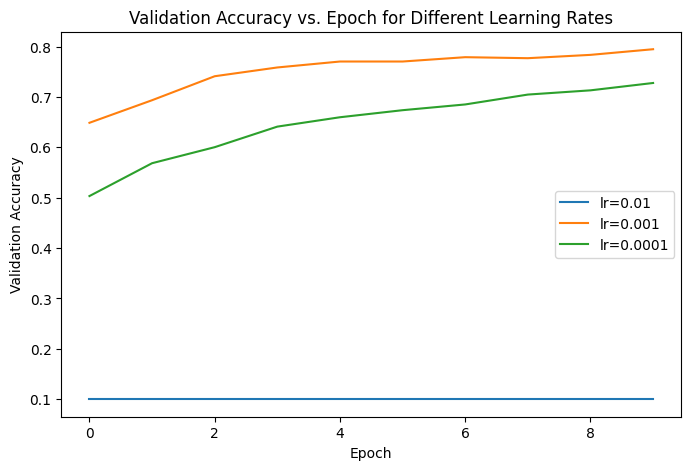

In [15]:
import tensorflow as tf
learning_rates = [1e-2, 1e-3, 1e-4]
histories_lr = {}

for lr in learning_rates:
    print(f"Training BaselineCNN with lr = {lr}")
    model = build_baseline_cnn()
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    histories_lr[lr] = model.fit(
        x_train_sub, y_train_sub,
        validation_data=(x_val, y_val),
        epochs=10,
        batch_size=64,
        verbose=2
    )

# Plot validation accuracy for each learning rate
plt.figure(figsize=(8,5))
for lr, hist in histories_lr.items():
    plt.plot(hist.history['val_accuracy'], label=f'lr={lr}')
plt.title('Validation Accuracy vs. Epoch for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

- $lr = 1e-2$: Validation accuracy never rose above ~10%, indicating the optimizer diverged or got stuck.
- $lr = 1e-4$: Training was stable but relatively slow; validation accuracy only reached ~72-73% after 10 epochs.
- $lr = 1e-3$: Achieved the fastest convergence and highest peak validation accuracy within 10 epochs.

Thus, the optimal learning rate from our grid search was $lr = 1e-3$, balancing exploration and exploitation.

# Step 5: Conclusion
For this final, we tackled the CIFAR-10 image classification task by developing and comparing three convolutional architectures: a custom 4-layer CNN, ResNet-18, and EfficientNet-B0. Through EDA, we confirmed that the dataset is balanced across the 10 possible image categories, requires per-channel normalization, and is sufficiently clean to proceed without additional cleaning stages. The baseline CNN achived a 79% test accuracy but eventually showed signs of overfitting. ResNet-18 w/ residual connections delivered the best performance at 82.8%, while EfficientNet-B0 trained from scratch underperformed at 70%, suggesting that compound-scaling models benefit from pretraining.

Hyperparameter optimization revealed that an Adam optimizer with a LR = 1e-3 provided the optimal balance between convergence speed and stability. Lower leraning rates converged too slowly, and higher rates led to divergence.

Overall, this project demonstrates how architecture choice, normalization, and careful tuning combine to drive performance on low-res image classification. The superior accuracy of ResNet-18 validates residual learning for CIFAR-10, while the controlled experiments lay a solid foundation for further model and augmentation studies.  

# Resources

Will Cukierski. CIFAR-10 - Object Recognition in Images. https://kaggle.com/competitions/cifar-10, 2013. Kaggle.

# GitHub
https://github.com/JeffreyLind3/CSCA5642Week6